In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap

In [13]:
# Load the data
df_pbs = pd.read_csv('../pbs_c/cmake-build-debug/pbsBlocks.csv')
df_cmp = pd.read_csv('../pbs_c/cmake-build-debug/comparison.csv')

In [3]:
df_pbs.describe()

,Block Number,Proposer ID,Builder ID,Winning Bid Value,Winning Block Value,Reward,Builder ID 1 Bid,Builder ID 2 Bid,Builder ID 3 Bid,Builder ID 4 Bid,...,Builder ID 1 Block Value,Builder ID 2 Block Value,Builder ID 3 Block Value,Builder ID 4 Block Value,Builder ID 5 Block Value,Builder ID 10 Block Value,Builder ID 30 Block Value,Builder ID 50 Block Value,Builder ID 70 Block Value,Builder ID 90 Block Value
count,500.000000,500.00000,500.00000,500.000000,500.000000,500.000000,500.00000,500.00000,500.00000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,28.40800,31.05000,318.225000,491.086226,172.861220,277.77300,280.72700,283.78300,286.927000,...,417.699878,419.723436,422.093214,422.804720,422.804720,531.165972,530.493976,531.165972,531.165972,530.493976
std,144.481833,31.61304,31.68437,66.075076,96.807861,96.764021,93.62152,93.42842,90.06186,86.509253,...,99.284633,95.597051,93.266440,92.813049,92.813049,88.419126,89.054537,88.419126,88.419126,89.054537
min,1.000000,1.00000,1.00000,0.000000,232.689000,36.567000,0.00000,0.00000,0.00000,0.000000,...,90.663200,155.274000,155.274000,155.274000,155.274000,232.689000,232.689000,232.689000,232.689000,232.689000
25%,125.750000,3.00000,4.00000,295.250000,420.284500,103.541750,240.87500,245.25000,253.00000,256.375000,...,359.898000,360.299750,363.479750,363.855500,363.855500,477.133000,476.827750,477.133000,477.133000,476.827750
50%,250.500000,10.00000,10.00000,337.000000,486.075000,144.555000,303.50000,305.00000,303.25000,306.000000,...,419.273500,419.273500,420.271000,421.019000,421.019000,531.736000,530.917500,531.736000,531.736000,530.917500
75%,375.250000,50.00000,50.00000,353.125000,556.077500,221.289750,343.62500,343.50000,344.50000,344.625000,...,476.594750,476.594750,476.594750,476.594750,476.594750,582.877750,582.877750,582.877750,582.877750,582.877750
max,500.000000,90.00000,90.00000,773.500000,1048.890000,700.817000,773.00000,773.00000,773.00000,807.000000,...,958.518000,958.518000,958.518000,958.518000,958.518000,1048.890000,1048.890000,1048.890000,1048.890000,1048.890000


In [4]:
def get_builder_type(id):
    if 1 <= id <= 9:
        return 'Normal Proposer Builder'
    elif 10 <= id <= 999:
        return 'MEV Proposer Builder'
    else:
        return 'Unknown Builder'

def adjust_builder_id(id):
    if(get_builder_type(id) == 'MEV Proposer Builder'):
        return int(int(id) / 20 + 1)
    else:
        return id

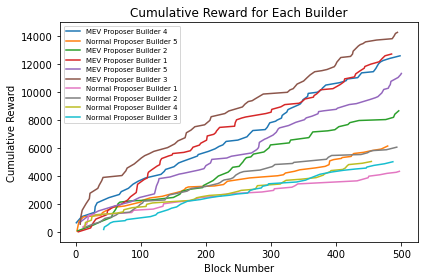

In [6]:
builder_ids = df_pbs['Builder ID'].unique()
fig, axs = plt.subplots()
for builder_id in builder_ids:
    builder_df_pbs = df_pbs[df_pbs['Builder ID'] == builder_id]
    cumulative_rewards = np.cumsum([reward for reward, id in zip(df_pbs['Reward'], df_pbs['Builder ID']) if id == builder_id])
    axs.plot(builder_df_pbs['Block Number'].values, cumulative_rewards, label=f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}')

axs.set_title('Cumulative Reward for Each Builder')
axs.set_xlabel('Block Number')
axs.set_ylabel('Cumulative Reward')
axs.legend(loc='best',prop={'size': 7})
plt.tight_layout()
plt.show()

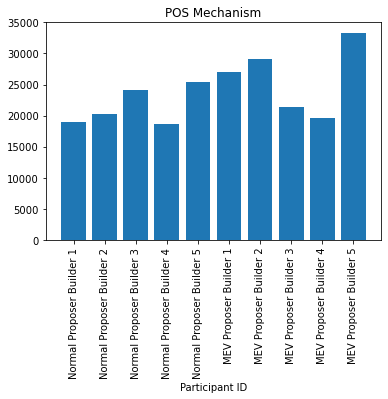

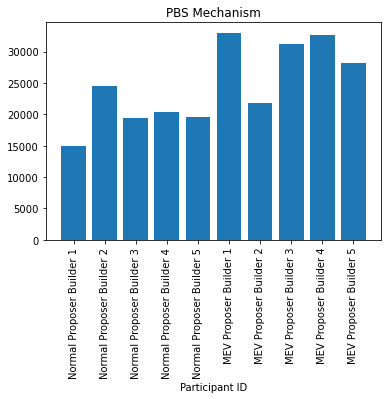

In [19]:
total_rewards_pos = []
total_rewards_pbs = []
builder_ids = np.sort(df_pbs['Builder ID'].unique())

for builder_id in builder_ids:
    cumulative_rewards_pbs = ([reward for reward, id in zip(df_pbs['Reward'], df_pbs['Builder ID']) if id == builder_id]+
                                    [bid for bid, id in zip(df_pbs['Winning Bid Value'], df_pbs['Proposer ID']) if id == builder_id])
    total_rewards_pbs.append(sum(cumulative_rewards_pbs))

    cumulative_rewards_pos = [reward for reward, id in zip(df_cmp['POS Block Value'], df_cmp['POS Builder ID']) if id == builder_id]
    total_rewards_pos.append(sum(cumulative_rewards_pos))


builder_ids = [f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}' for builder_id in builder_ids]
plt.bar(builder_ids, total_rewards_pos)
plt.title('POS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()

plt.bar(builder_ids, total_rewards_pbs)
plt.title('PBS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()



In [22]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)
    x = x

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [24]:
gini_pbs = gini(total_rewards_pbs)
gini_pos = gini(total_rewards_pos)

print(f'Gini coefficient for PBS rewards: {gini_pbs}')
print(f'Gini coefficient for POS rewards: {gini_pos}')

Gini coefficient for PBS rewards: 0.13803020787753723
Gini coefficient for POS rewards: 0.10918090284914628
